# Siamese Neural Network

Siamese neural network is a class of neural network architectures that contain two or more identical sub networks. identical here means they have the same configuration with the same parameters and weights. Parameter updating is mirrored across both sub networks.It is used find the similarity of the inputs by comparing its feature vectors.

For more details check this blog : https://innovationincubator.com/siamese-neural-network-with-code-example/

## Steps to create classifier using Siamese Neural Network


1.   **Data Preprocessing**
2.   **Define the Siamese Network**
3.   **Feature Vector Extraction**
4.   **Similarity Score Calculation**
5.   **Defininf Loss Function**
6.   **Optimizer**
7.   **Testing using One-Shot Learnig**
8.   **Making Predictions**



Let's  go step wise

## Import and Install all the necessary packages

In [1]:
# Import all the necessary Library
import torchvision
import torch.utils.data as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
import os
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/Siamese_Network/Signaturedata.zip

Archive:  /content/drive/MyDrive/Siamese_Network/Signaturedata.zip
  inflating: sign_data/sign_data/test/049/01_049.png  
  inflating: sign_data/sign_data/test/049/02_049.png  
  inflating: sign_data/sign_data/test/049/03_049.png  
  inflating: sign_data/sign_data/test/049/04_049.png  
  inflating: sign_data/sign_data/test/049/05_049.png  
  inflating: sign_data/sign_data/test/049/06_049.png  
  inflating: sign_data/sign_data/test/049/07_049.png  
  inflating: sign_data/sign_data/test/049/08_049.png  
  inflating: sign_data/sign_data/test/049/09_049.png  
  inflating: sign_data/sign_data/test/049/10_049.png  
  inflating: sign_data/sign_data/test/049/11_049.png  
  inflating: sign_data/sign_data/test/049/12_049.png  
  inflating: sign_data/sign_data/test/049_forg/01_0114049.PNG  
  inflating: sign_data/sign_data/test/049_forg/01_0206049.PNG  
  inflating: sign_data/sign_data/test/049_forg/01_0210049.PNG  
  inflating: sign_data/sign_data/test/049_forg/02_0114049.PNG  
  inflating: sign

### Additional Utility Functions

In [5]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [6]:
# First, look at everything.
from subprocess import check_output
print(check_output(["ls", "/content/sign_data"]).decode("utf8"))



sign_data
test
test_data.csv
train
train_data.csv



In [7]:
class Config():
    training_dir = "/content/sign_data/train"
    testing_dir = "/content/sign_data/test"
    train_batch_size = 32
    train_number_epochs = 20

## Load Dataset :

Datasets can be downloaded from this Link:  https://drive.google.com/file/d/1q03FLpaolm6Jq5vM0a_AEnjJoqjtxgP8/view?usp=sharing

**Copy the dataset directly to your drive and load it from there**

In [11]:
training_dir="/content/sign_data/train"
training_csv="/content/sign_data/train_data.csv"
testing_csv="/content/sign_data/test_data.csv"
testing_dir="/content/sign_data/test_data.csv"

### Preprocessing and Loading Dataset

We preprocessed all the images and loaded them as .npy files which is easy to transfer . You can follow your own preprocessing steps .


In [9]:
class SiameseNetworkDataset():

    def __init__(self,training_csv=None,training_dir=None,transform=None):
        # used to prepare the labels and images path
        self.training_df=pd.read_csv(training_csv)
        self.training_df.columns =["image1","image2","label"]
        self.training_dir = training_dir
        self.transform = transform

    def __getitem__(self,index):

        # getting the image path
        image1_path=os.path.join(self.training_dir,self.training_df.iat[index,0])
        image2_path=os.path.join(self.training_dir,self.training_df.iat[index,1])


        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1 , torch.from_numpy(np.array([int(self.training_df.iat[index,2])],dtype=np.float32))

    def __len__(self):
        return len(self.training_df)

In [12]:
# Load the the dataset from raw image folders
siamese_dataset = SiameseNetworkDataset(training_csv,training_dir,
                                        transform=transforms.Compose([transforms.Resize((105,105)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       )

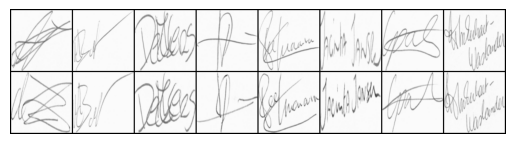

[[1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]]


In [13]:
# Viewing the sample of images and to check whether its loading properly
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Siamese Network Definition

In [14]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(

            nn.Conv2d(1, 96, kernel_size=11,stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

        )

        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),

            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),

            nn.Linear(128,2))



    def forward_once(self, x):
        # Forward pass
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2


### Loss Function

### Train the Model

In [15]:
# Check whether you have GPU is loaded or not
if torch.cuda.is_available():
    print('Yes')

In [20]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# # Train the model
#model = train()
#torch.save(model.state_dict(), "model.pt")
#print("Model Saved Successfully")

# Test the Model

In [21]:
# Load the saved model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load("../input/siamese-model1/model.pt"))

FileNotFoundError: [Errno 2] No such file or directory: '../input/siamese-model1/model.pt'

In [18]:
# Load the test dataset
test_dataset = SiameseNetworkDataset(training_csv=testing_csv,training_dir=testing_dir,
                                        transform=transforms.Compose([transforms.Resize((105,105)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       )

test_dataloader = DataLoader(test_dataset,num_workers=6,batch_size=1,shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [19]:
# Print the sample outputs to view its dissimilarity
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
for i, data in enumerate(test_dataloader,0):
  x0, x1 , label = data
  concatenated = torch.cat((x0,x1),0)
  output1,output2 = model(x0.to(device),x1.to(device))
  eucledian_distance = F.pairwise_distance(output1, output2)
  if label==list_0:
    label="Orginial"
  else:
    label="Forged"
  imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance.item(),label))
  counter=counter+1
  if counter ==20:
     break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


NotADirectoryError: Caught NotADirectoryError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-9-1b821f65ca0b>", line 18, in __getitem__
    img0 = Image.open(image1_path)
  File "/usr/local/lib/python3.10/dist-packages/PIL/Image.py", line 3227, in open
    fp = builtins.open(filename, "rb")
NotADirectoryError: [Errno 20] Not a directory: '/content/sign_data/test_data.csv/062/02_062.png'
